In [1]:
import matplotlib.pyplot as plt
from PIL import Image

import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
import sys 
sys.path.append('..')
from models import get_net
net = get_net("WILDCAM")

irm_model = net(n_classes=2)
print("loading IRM model")
irm_model.load_state_dict(torch.load("../models/wildcam_1501_0.001_40_10000.0_IRM.pth", map_location="cpu"))
irm_model.to("cpu")

loading IRM model


resnet18_extractor(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [3]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [4]:
def batch_predict(images):
    clf.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    clf.to(device)
    batch = batch.to(device)
    
    logits = clf(batch)
    #probs = torch.sigmoid(logits)
    probs = 1-torch.sigmoid(logits)
    #probs = torch.cat((1-torch.sigmoid(logits), torch.sigmoid(logits)), 1)
    return probs.detach().cpu().numpy()[0][0]

In [5]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 

In [6]:
#raccoon_images = os.listdir("../../../../data/wildcam_subset_sample/test/raccoon")
coyote_images = os.listdir("../../../../data/wildcam_subset_sample/test/coyote")

In [7]:
clf = irm_model
test_pred = []
#images = raccoon_images
images = coyote_images
#path = "../../../../data/wildcam_subset_sample/test/raccoon"
path = "../../../../data/wildcam_subset_sample/test/coyote"
for img in images:
    img = get_image(os.path.join(path, img))
    test_pred.append(batch_predict([pill_transf(img)]))
test_pred

[0.5021099,
 0.45310378,
 0.5345704,
 0.7277298,
 0.98197055,
 0.467768,
 0.39606643,
 0.58543104,
 0.9803152,
 0.50046575,
 0.7519061,
 0.4260434,
 0.97441965,
 0.96619356,
 0.9810916,
 0.9836712,
 0.42024547,
 0.56562424,
 0.98111457,
 0.9848185,
 0.955292,
 0.4042129,
 0.5034459,
 0.47851402,
 0.51427186,
 0.44845766,
 0.6173131,
 0.95951235,
 0.55631435,
 0.722754,
 0.9693969,
 0.9642119,
 0.98071796,
 0.99028176,
 0.9759954,
 0.73529047,
 0.83406854,
 0.51376176,
 0.9920616,
 0.9846776,
 0.35758173,
 0.4177943,
 0.38905728,
 0.81356627,
 0.7412869,
 0.30650097,
 0.99215186,
 0.9847243,
 0.5423255,
 0.36374217,
 0.38782775,
 0.5281231,
 0.9703993,
 0.3956687,
 0.98387825,
 0.5546512,
 0.5497818,
 0.6332011,
 0.352296,
 0.9748576,
 0.4471901,
 0.79440176,
 0.9706048,
 0.98303825,
 0.98396534,
 0.9748855,
 0.4778192,
 0.4439205,
 0.35159612,
 0.653113,
 0.33490592,
 0.5664897,
 0.5331962,
 0.56783366,
 0.37993413,
 0.777485,
 0.6746075,
 0.3884548,
 0.9779575,
 0.5119269,
 0.72683704

In [8]:
res = sorted(range(len(test_pred)), key = lambda sub: test_pred[sub])[-20:] 
res

[139,
 63,
 183,
 155,
 15,
 54,
 64,
 124,
 200,
 39,
 47,
 19,
 133,
 168,
 174,
 203,
 138,
 33,
 38,
 46]

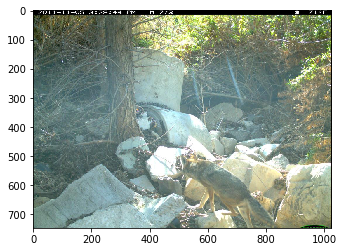

In [30]:
# raccoon - 183, 155, 15, 64, 124, 47, 
img = get_image(os.path.join(path, images[46]))
plt.imshow(img)

In [10]:
images[133] 

'594843d0-23d2-11e8-a6a3-ec086b02610b.jpg'